# Подход 1: градиентный бустинг "в лоб".

Для того, чтобы перейти к отчету необходимо пролистать в самый конец блокнота.

## 1. Загрузка и предварительная обработка данных.

In [392]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

In [393]:
df_train = pd.read_csv('features.csv',  index_col='match_id')
df_train[df_train.columns.values[0:10]].head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items
match_id,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7
1,1430220345,0,42,4,1188,1033,9,0,1,12
2,1430227081,7,33,4,1319,1270,22,0,0,12
3,1430263531,1,29,4,1779,1056,14,0,0,5
4,1430282290,7,13,4,1431,1090,8,1,0,8


In [394]:
match_res_col = ['duration', 
                 'radiant_win', 
                 'tower_status_radiant', 
                 'tower_status_dire', 
                 'barracks_status_radiant', 
                 'barracks_status_dire']

X = df_train.drop(match_res_col, axis=1)
y = df_train['radiant_win'].to_frame()

## 2. Проверка выборки на наличие пропусков в данных. 

Названия признаков в которых есть пропуски в данных.

In [395]:
nan_columns = X.columns.values[X.isnull().sum() > 0]
print('List of features that have omissions: ')
for i in range(nan_columns.shape[0]):
    print('\t{0}. {1}'.format(i+1, nan_columns[i]))

List of features that have omissions: 
	1. first_blood_time
	2. first_blood_team
	3. first_blood_player1
	4. first_blood_player2
	5. radiant_bottle_time
	6. radiant_courier_time
	7. radiant_flying_courier_time
	8. radiant_first_ward_time
	9. dire_bottle_time
	10. dire_courier_time
	11. dire_flying_courier_time
	12. dire_first_ward_time


## 3. Сравнение способов заполнения пропусков в данных.

Сравним между собой три варианта заполнения пропусков в данных для градиентного бустинга (в дальнейшем ГБ) с числом решающих деревьев N=[10, 20, 30]:
- Заполнение пропусков нулями.
- Заполнение пропусков числом намного большим чем значения в таблице.
- Заполнение медианами по соответствующему столбцу.

In [238]:
# Train datasets for different approaches to fill NaN values
XX = [X.fillna(0), X.fillna(-1e8), X.fillna(X.median())]

roc_scores = []
estimators_numb = [5, 10, 20, 30]
cv = KFold(n_splits=5, shuffle=True, random_state=241)

for x in XX:
    tmp = []
    for est_numb in estimators_numb:
        clf = GradientBoostingClassifier(n_estimators=est_numb, verbose=False, random_state=241)
        tmp.append( np.mean(cross_val_score(clf, x, y, scoring='roc_auc', cv=cv)) )
    roc_scores.append(tmp)

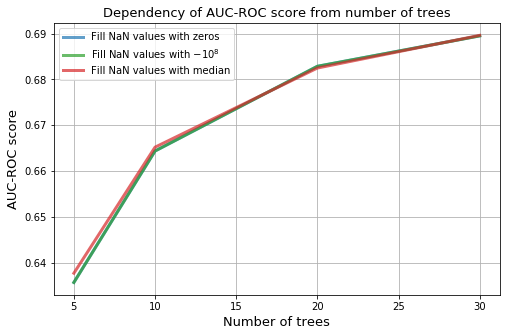

In [239]:
labels = [r'Fill NaN values with zeros', 
          r'Fill NaN values with $-10^{8}$', 
          r'Fill NaN values with median']
colors= ['C0', 'C2', 'C3']

fig, ax = plt.subplots(figsize=(8,5))

for i in range(len(roc_scores)):
    ax.plot(estimators_numb, roc_scores[i], label = labels[i], color=colors[i], alpha=0.7, lw=3)

ax.set_title('Dependency of AUC-ROC score from number of trees', fontsize=13)
ax.set_xlabel('Number of trees', fontsize=13)
ax.set_ylabel('AUC-ROC score', fontsize=13)
ax.grid('on')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

plt.show()

**Вывод**: на данной выборке тип заполнения пропусков в данных не влияет существенно на результат работы алгоритма Градиентного бустинга. 
Поэтому выберем тип заполнения предложенный в пособии, а именно - заполнение пропусков в данных нулями.

In [396]:
X = X.fillna(0.)

## 4. Сравнение кросс-валидации для полной выборки и ее половины.

Для выявления возможности ускорения обучения методом ГБ сравним:
- Время вычисления кросс-валидации для всей выборки и ее половины, выбранной случайным образом.
- Качество результатов кросс-валидации для всей выборки и ее половины, выбранной случайным образом.

**Замечание**: В идеальном случае необходимо сформировать несколько случайно сгенерированных выборок размера равного половине выборки: $X_{1},X_{2},...X_{n}$ и усреднить полученные для них значения времени вычисления кросс-валидации и полученного при этом качества обучения.

In [241]:
# Generate dataset with size is equal to half of initial dataset
X_half = X.sample(frac=0.5, random_state=241)
y_half = y.sample(frac=0.5, random_state=241)

roc_score_full = []
roc_score_half = []
# Stores elapsed time of cross-validation for full(half) dataset
el_time_full = []
el_time_half = []

for est_numb in estimators_numb:
    clf = GradientBoostingClassifier(n_estimators=est_numb, verbose = False, random_state=241)
    
    time_f = datetime.datetime.now()
    roc_score_full.append( np.mean(cross_val_score(clf, X, y, scoring='roc_auc', cv=cv)) )
    el_time_full.append( datetime.datetime.now()-time_f )
    
    time_h = datetime.datetime.now()
    roc_score_half.append( np.mean(cross_val_score(clf, X_half, y_half, scoring='roc_auc', cv=cv)) ) 
    el_time_half.append(datetime.datetime.now()-time_h) 

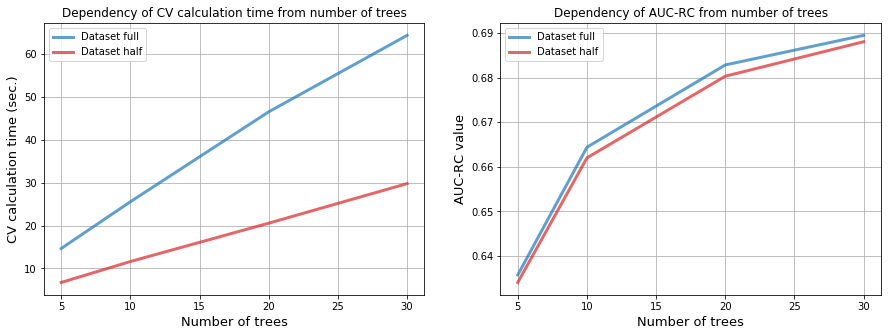

Average time gain with half dataset = 2.443


In [242]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(estimators_numb, map(lambda x : x.total_seconds(), el_time_full), color ='C0', label = 'Dataset full', alpha=0.7, lw=3)
ax[0].plot(estimators_numb, map(lambda x : x.total_seconds(), el_time_half), color ='C3', label = 'Dataset half', alpha=0.7, lw=3)
ax[0].set_title('Dependency of CV calculation time from number of trees')
ax[0].set_xlabel('Number of trees', fontsize=13)
ax[0].set_ylabel('CV calculation time (sec.)', fontsize=13)

ax[1].plot(estimators_numb, roc_score_full, color ='C0', label = 'Dataset full', alpha=0.7, lw=3)
ax[1].plot(estimators_numb, roc_score_half, color ='C3', label = 'Dataset half', alpha=0.7, lw=3)
ax[1].set_title('Dependency of AUC-RC from number of trees')
ax[1].set_xlabel('Number of trees', fontsize=13)
ax[1].set_ylabel('AUC-RC value', fontsize=13)

for i in range(2):
    ax[i].grid('on')
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].legend(handles, labels)

plt.show()

avg_time_gain = np.mean( np.array(map(lambda x : x.total_seconds(), T)) / 
                     np.array(map(lambda x : x.total_seconds(), t)))

print('Average time gain with half dataset = {:.3f}'.format(avg_time_gain))

**Вывод**: По полученным графикам видно, что среднее время кросс-валидации для выборки из половины элементов значительно уменьшилось (в 2.4 раза), в то время как качество обучения практически не изменилось, таким образом процесс обучения можно ускорить производя кросс-валидацию не для всей выборки, а для какой-то ее части.

### 5. Вычисление качества обучения для различного числа деревьев.

Ниже будет проведено исследование влияния количества деревьев на качество обучения. 

Для этого сравним качества обучения для количества деревьев из массива N=[5, 10, 20, 30, 50, 100, 200].

In [81]:
roc_scores = []
elapsed_time = []
estimators_numb = [5, 10, 20, 30, 50, 100, 200]
cv = KFold(n_splits=5, shuffle=True, random_state=241)

for est_numb in estimators_numb:
    time = datetime.datetime.now()
    clf = GradientBoostingClassifier(n_estimators  = est_numb, verbose = False, random_state=241)
    score = np.mean(cross_val_score(clf, X, y, scoring = 'roc_auc', cv=cv))
    
    roc_scores.append(score)
    elapsed_time.append(datetime.datetime.now() - time)

Calulations finished


5 estimators,	 T=0:00:46.584000
10 estimators,	 T=0:01:20.686000
20 estimators,	 T=0:02:25.513000
30 estimators,	 T=0:03:30.923000
50 estimators,	 T=0:05:46.857000
100 estimators,	 T=0:07:38.565000
200 estimators,	 T=0:13:14.086000


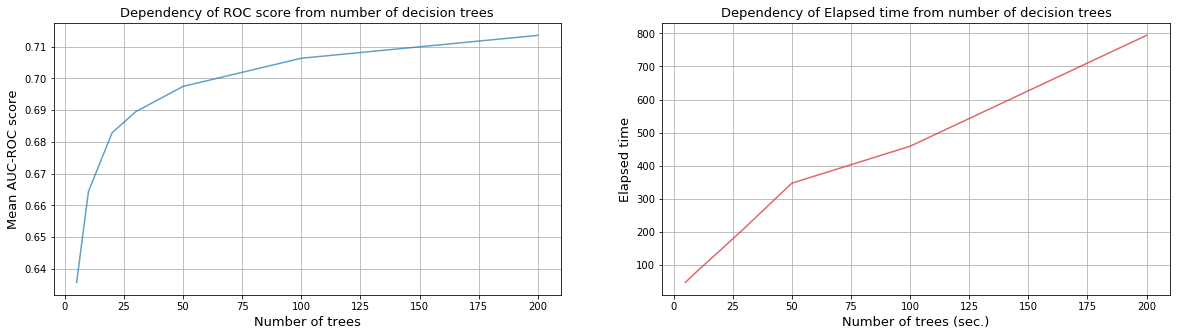

In [104]:
for i in range(len(elapsed_time)):
    print('{0} estimators,\t T={1}'.format(estimators_numb[i], elapsed_time[i]))

fig, ax = plt.subplots(1, 2,figsize=(20,5))

ax[0].plot(estimators_numb, roc_scores, color='C0', alpha=0.7)
ax[0].set_title('Dependency of ROC score from number of decision trees', fontsize=13)
ax[0].set_xlabel('Number of trees', fontsize=13)
ax[0].set_ylabel('Mean AUC-ROC score', fontsize=13)
ax[0].grid('on')

ax[1].plot(estimators_numb, map(lambda x : x.total_seconds(), elapsed_time), color='C3', alpha=0.7)
ax[1].set_title('Dependency of Elapsed time from number of decision trees', fontsize=13)
ax[1].set_xlabel('Number of trees (sec.)', fontsize=13)
ax[1].set_ylabel('Elapsed time', fontsize=13)
ax[1].grid('on')

plt.show()

**Вывод**: При увеличении числа решающих деревьев происходит рост качества обучения с 0.69 (при N=30) до 0.72 (при N=200), поэтому стоит использовать число деревьев больше тридцати в том случае, если время выполнения не является приоритетом.

## Градиентный бустинг. Отчет.

### 1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?

Признаки, имеющие пропуски можно разделить на две категории:
1. Событие First blood не произошло в первые пять минут игры, например, (опишем 2 признака):
    - `first_blood_time`: игровое время первой крови не произошло в течении первых пяти минут игры.
    - `first_blood_team`: индекс команды, совершившей первую кровь пропущен, т.к. событие First blood не произошло в течении первых пяти минут игры.
2. Команда не купила в течении первых пяти минут матча определенные типы предметов (опишем 2 признака):
    - `radiant_bottle_time`: поле пропущено, если первое приобретение командой предмета "bottle" произошло после пятой минуты игры.
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля произошло после пятой минуты игры.

### 2. Как называется столбец, содержащий целевую переменную?

Столбец, содержащий целевую переменную должен содержать в себе результаты предсказания алгоритма (победа первой или второй команды).
Поэтому из описания задачи следует что столбец содержащий целевую переменную это столбец под названием `radiant_win`.

### 3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Какое качество при этом получилось? Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

Кросс-валидация проводилась для градиентного бустинга с числом решающих деревьев из списка N=[5, 10, 20, 30, 50, 100, 200].

Время выполнения кросс-валидации практически линейно растёт с увеличением числа решающих деревьев, и для N=30 составляет 0:03:31 при качестве обучения 0.69.

При увеличении числа решающих деревьев происходит рост качества обучения на кросс-валидации с 0.69 (при N=30) до 0.72 (при N=200), поэтому стоит использовать число деревьев больше тридцати в том случае, если время выполнения кросс-валидации не является приоритетом.

Для ускорения обучения с ростом числа деревьев:
- Проводить кросс-валидацию не на всей выборке, а на некотором ее подмножестве (время работы уменьшается в среднем в 2.4 раза).
